In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import losses, metrics

In [3]:
BATCH_SIZE = 8
ITERATIONS = 300

### Data Preparation

In [4]:
def preprocess(image, label):
    return tf.cast(image, dtype=tf.float32)/255, label

train_data = tfds.load("stl10", split="train", as_supervised=True, shuffle_files=False, data_dir="../data")
train_data = train_data.map(preprocess).batch(BATCH_SIZE)

label_map = ['plane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'primate', 'boat', 'truck']

2023-05-21 18:28:31.854778: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-05-21 18:28:31.888899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2023-05-21 18:28:31.889121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-21 18:28:31.890726: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-21 18:28:31.891632: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-05-21 18:28:31.891858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

In [5]:
classifier = tf.saved_model.load("../checkpoints/classifier")

## DeepFool Attack

In [161]:
def compute_w_and_f(model, images, labels, num_classes=10):
    """
    Class 마다의 w, f를 계산

    Arguments:
    ----------
    - model: 분류기
    - images: (N, H, C, W) 변형할 이미지
    - labels: (N, num_classes) 실제 라벨
    - num_classes

    Returns:
    --------
    - w
    - f
    """

    N = len(images)
    images.trainable = True
    ps_for_labels = []
    ps_list_per_class = []
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(images)
        logits, ps = model(images) # logits, 확률값 리턴

        ps_for_labels = [ps[i, labels[i]] for i in range(N)]
        ps_list_per_class = [ps[:, c] for c in range(num_classes)]

    ps_for_labels = tf.stack(ps_for_labels, axis=0)
    ps_for_labels = tf.expand_dims(ps_for_labels, axis=-1)
    f = ps - ps_for_labels

    gradients_list = []

    # class별로 f 미분
    for c in range(num_classes):
        gradients = tape.gradient(ps_list_per_class[c], [images])[0]
        gradients_list.append(gradients)

    gradients = tf.stack(gradients_list, axis=1)
    gradients_for_labels = [gradients[i, labels[i]] for i in range(N)]
    gradients_for_labels = tf.stack(gradients_for_labels, axis=0)
    gradients_for_labels = tf.expand_dims(gradients_for_labels, axis=1)
    w = gradients - gradients_for_labels

    return w, f


def predict(model, image):
    pred = model(image)[0]
    pred = tf.argmax(pred, axis=-1)
    return pred


def deepfool(model, images, labels):
    N = len(images)
    x = images

    while True:
        w, f = compute_w_and_f(model, x, labels)
        w_norm_square = tf.reduce_sum(w**2, axis=(2, 3, 4))
        w_norm = tf.sqrt(w_norm_square)

        # target class 선택
        l = tf.abs(f) / w_norm
        l = l.numpy()
        for i in range(N):
            l[i, labels[i]] = 9999
        l = np.argmin(l, axis=-1)
        
        # perturbation 계산
        r = [(tf.abs(f[i, l[i]]) / w_norm_square[i, l[i]]) * w[i, l[i]] for i in range(N)]
        r = tf.stack(r, axis=0)
        
        # 라벨이 바뀌었는지에 대한 마스크: True면 안바뀐것을, False 면 바뀌었다는 것을 의미
        pred = predict(model, x)
        mask = labels.numpy() == pred.numpy()

        if mask.sum() == 0: break # 공격 다 했으면 리턴

        # 이미 공격 성공한 이미지는 업데이트안함
        x = [x[i] + r[i] for i in range(N) if mask[i] == True]

        # stacking & clipping
        x = tf.stack(x, axis=0)
        x = tf.clip_by_value(x, 0, 1)

    return x

True label / prediction


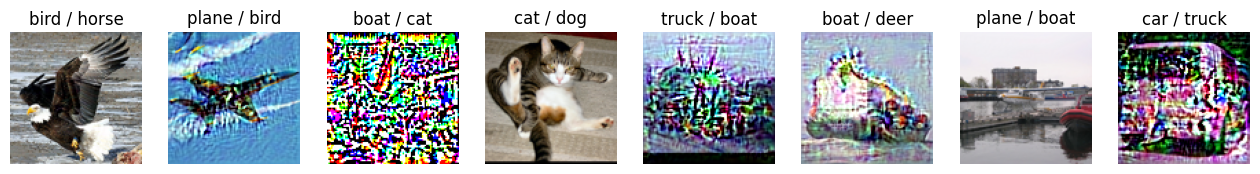

In [162]:
images, labels = next(iter(train_data))
image_fake = deepfool(classifier, images, labels)
pred = predict(classifier, image_fake)

print("True label / prediction")
plt.figure(figsize=(16, 3))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(image_fake.numpy()[i])
    plt.axis("off")
    plt.title(f"{label_map[labels.numpy()[i]]} / {label_map[pred.numpy()[i]]}")

plt.show()